In [499]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure

def import_data() -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):
    return tf.keras.datasets.cifar100.load_data(label_mode="coarse")

In [500]:
(x_train, y_train), (x_test, y_test) = import_data()

#### Converting Images to Grayscale

In [501]:
def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train, gray_test

In [502]:
# x_train, x_test = convert_to_grayscale(x_train, x_test)

#### Increasing Constrast

In [503]:
def increase_image_contrast(image, strength):
    p_low, p_high = np.percentile(image, (strength, 100 - strength))
    return (exposure.rescale_intensity(image, in_range=(p_low, p_high))).astype(int)

def increase_all_contrast(train, test, strength):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i], strength)
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i], strength)
    return new_train, new_test

In [504]:
og_image = np.copy(x_train[0])
x_train, x_test = increase_all_contrast(x_train, x_test, 20)

#### Image Equalization

In [505]:
def equalize_hist(image):
    return (exposure.equalize_hist(image) * 255).astype(int)

def equalize_hist_all(train, test):
    new_train = np.zeros(len(train))
    new_test = np.zeros(len(test))
    for i in range(len(train)):
        new_train[i] = equalize_hist(train[i])
    for i in range(len(test)):
        new_test[i] = equalize_hist(test[i])
    return new_train, new_test

In [506]:
# x_train, x_test = equalize_hist_all(x_train, x_test)

In [507]:
def equalize_adapthist(image, clip_lim):
    return (exposure.equalize_adapthist(image, clip_limit=clip_lim) * 255).astype(int)

def equalize_adapthist_all(train, test, clip_limit):
    new_train = np.zeros(len(train))
    new_test = np.zeros(len(test))
    for i in range(len(train)):
        new_train[i] = equalize_adapthist(train[i], clip_limit)
    for i in range(len(test)):
        new_test[i] = equalize_adapthist(test[i], clip_limit)
    return new_train, new_test

In [508]:
# x_train, x_test = equalize_adapthist_all(x_train, x_test, 0.03)

In [509]:
img_rescale = increase_image_contrast(og_image, 20)
hist_eq_image = equalize_hist(og_image)
img_adapteq = equalize_adapthist(og_image, 0.02)

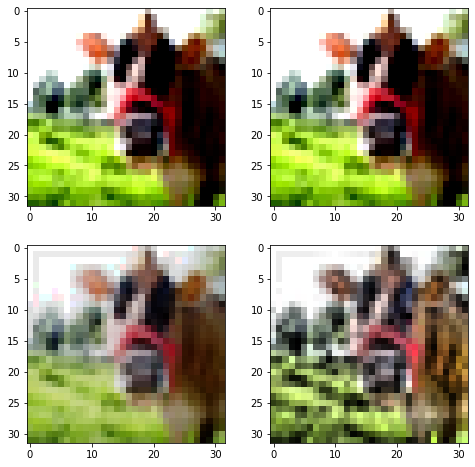

In [510]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2 
rows = 2
images = [x_train[0], img_rescale, hist_eq_image, img_adapteq]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i - 1])
plt.show()

#### Flattening the Images

In [511]:
def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

In [512]:
x_train, y_train, x_test, y_test = flatten_data(x_train, y_train, x_test, y_test)

In [513]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, verbose=1, bootstrap=False, max_features='log2')
model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                       verbose=1)

In [514]:
model.score(x_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


0.3191